## Comparison feature for QA4SM

The QA4SM web application service allows to validate one or more satellite soil moisture datasets against a reference. When a validation is run (after logging in, at `https://qa4sm.eu/validate/`), a netCDF result file is produced containing metadata and results by validation metric. 

Through the service it is possible to validate multiple satellite datasets against the same reference, therefore producing a horizontal comparison of the satellite products. However, this comparison is constrained by having the same temporal and spatial subsets, as well as scaling method, applied in all validations. Comparing the performance of a satellite product across for instance different time periods or areas of the Earth is possibly of great added value to the user, but currently not implemented in the service. To make up for this, a new feature is to be implemented in the web application in the form of a separate web page, where different validations can be drawn from the user's archive and compared to one another.

This notebook gives an overview of the concept for comparison of validation results. It is currently being developed in the [qa4sm-reader package](https://github.com/awst-austria/qa4sm-reader) QA4SMComparison Class. 

The Class can be initialized by giving a list of paths to netCDF result files. At the moment, all functionalities in the class (plots and table) work when the paths list includes 2 validations where the same reference is compared to one single satellite dataset (e.g A:B against A:C). A few plotting functions (`diff_plot()` and `diff_boxplot()`) can also work with more then three validations (e.g. A:B against A:C against A:D) or validations containing multiple comparison satellite datasets (e.g. A:B against A:C,D). However, for the moment the simplest case is considered where the same reference is compared to two distinct datasets.   

In [1]:
from qa4sm_reader.comparing import QA4SMComparison
import qa4sm_reader.globals
import os

os.chdir('./example_data/validations_nc')

# two validations only differ by validation period
paths = ['0-C3S.sm_with_1-GLDAS.SoilMoi0_10cm_inst.nc', '0-C3S.sm_with_1-GLDAS.SoilMoi40_100cm_inst.nc']

In [2]:
%%time
comp = QA4SMComparison(paths)

CPU times: user 186 ms, sys: 13.1 ms, total: 199 ms
Wall time: 286 ms


In [3]:
# the comparison attribute is a dictionary with {path: ID, QA4SMImg}.
#each image is assigned a name that identifies it, together with the ID:
for n, img in comp.comparison.values():
    print("{}-{}".format(n, img.name))

0-ref: C3S (v201912) v datasets: GLDAS (NOAH025 3H.2.1)
1-ref: C3S (v201912) v datasets: GLDAS (NOAH025 3H.2.1)


The names of the images are fundamental to tell apart the different validation results. These same names are used in the plots and table and should be unambiguous. In this case, the two validations only differ by time period and can be easily identified by includig this in the name. However, if the purpose is to compare validations with different e.g. scaling options or extents, **a different method has to be identified!**


### Performing the comparison

Here is an overview of the available methods to perform the comparison.

#### Difference table

A first difference overview can be provided using the summary statistics of the validation results. In the table, an absolute and relative difference value between the medians of the two datasets is associated to each validation metric:

In [4]:
# just suppress warning for nans
import warnings
warnings.filterwarnings('ignore')
comp.diff_table()

,Median of 0: ref: C3S (v201912) v datasets: GLDAS (NOAH025 3H.2.1),Median of 1: ref: C3S (v201912) v datasets: GLDAS (NOAH025 3H.2.1),Difference of the medians (0 - 1)
# observations,601.0,574.0,27.0
Pearson's r,0.73,0.42,0.32
Pearson's r p-value,0.e+00,1.96e-25,-1.96e-25
Spearman's rho,0.67,0.44,0.23
Spearman's rho p-value,0.e+00,1.96e-27,-1.96e-27
Root-mean-square deviation,0.04,0.05,-0.02
Bias (difference of means),-2.01e-10,-2.27e-10,2.63e-11
Unbiased root-mean-square deviation,0.04,0.05,-0.02
Mean square error,1.3e-03,2.79e-03,-1.49e-03
Mean square error correlation,1.3e-03,2.79e-03,-1.49e-03


* **any ideas on how the table can be made more informative?**

#### Difference boxplot

The difference boxplot can be considered an extension of the boxplot utility to visualize the results of a single validation (on the [results page of QA4SM](https://qa4sm.eu/myruns/)). The boxplot can potentially accomodate any number of validations; the inter-validations comparison would look exactly the same for boxplots except that we are comparing e.g. 2 different years:

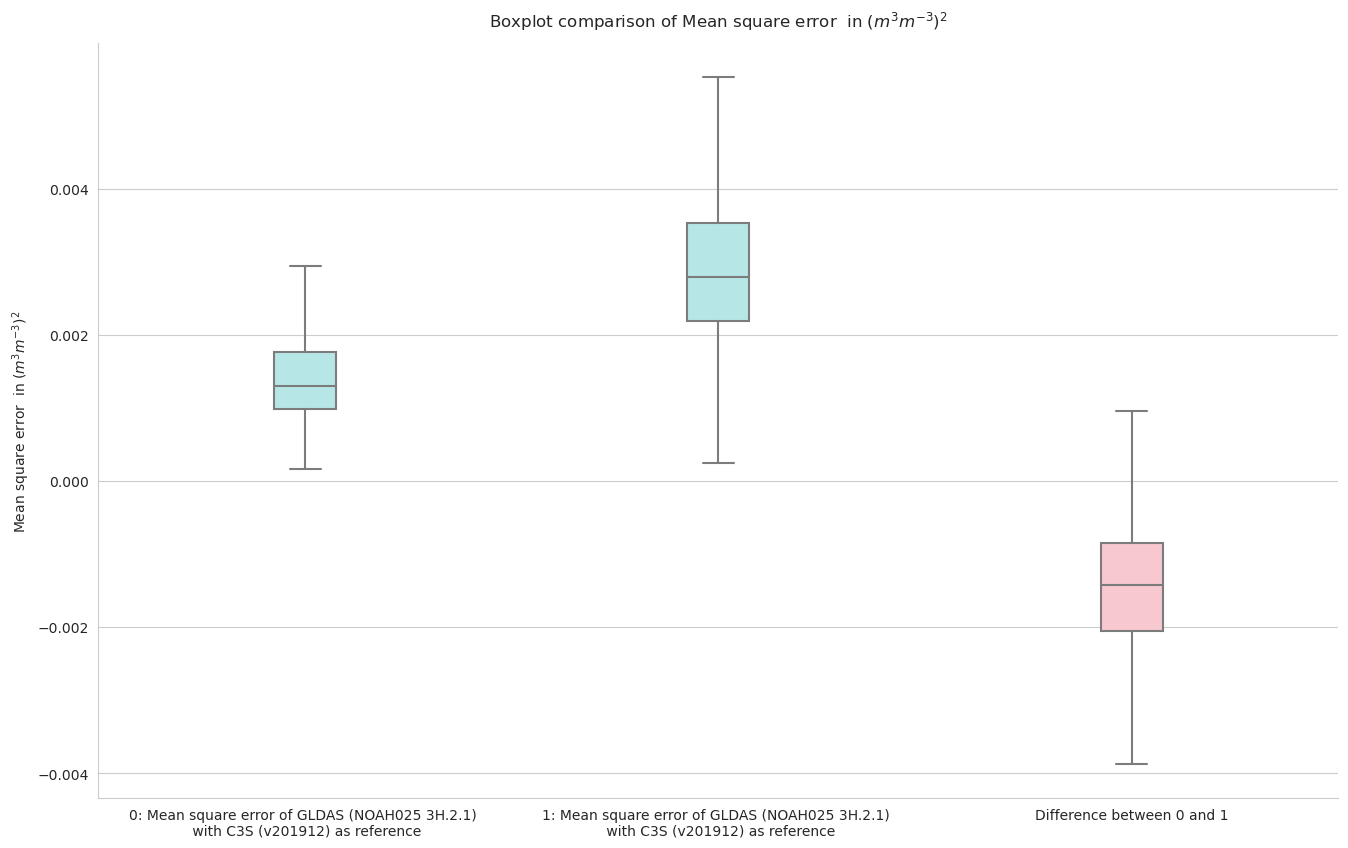

In [5]:
comp.diff_boxplot('mse')

Alternatively, a boxplot of the pairwise differences between the two validations could be shown, together with the individual results of the two validations:

#### Difference mapplot

A mapplot provides spatial information on the difference of performance between two validations. Below are different options to visualize the colorbar, according to the value of `diff_range`. **Which is the best option?**

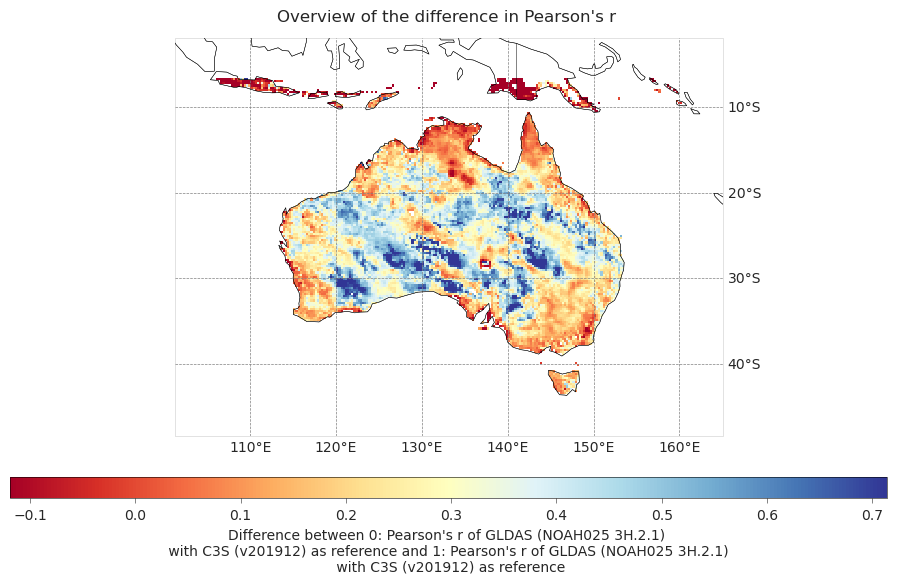

In [6]:
# metric needs to be specified. 'adjusted' has the colorbar in the same range of the difference values 
comp.diff_mapplot('R', diff_range='adjusted')

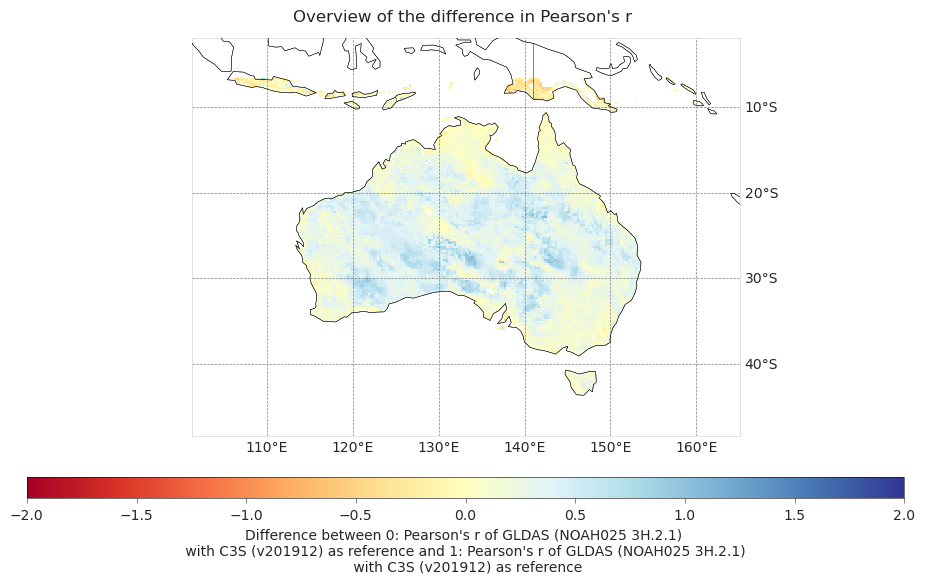

In [7]:
# metric needs to be specified. 'adjusted' has the colorbar going between fixed min and max, e.g.:
# for Pearson'r r -> [-2, 2]
comp.diff_mapplot('R', diff_range='fixed')

#### Difference plot

Another mean to provide a direct comparison between two or more validation results is a difference plot (Bland-Altman plot). This plots the mean against the difference of the values between two validation results; it is generally used to verify the agreement between two methods, but can also be visually interpreted to see whether there is a progressive difference in the results, for a certain metric:

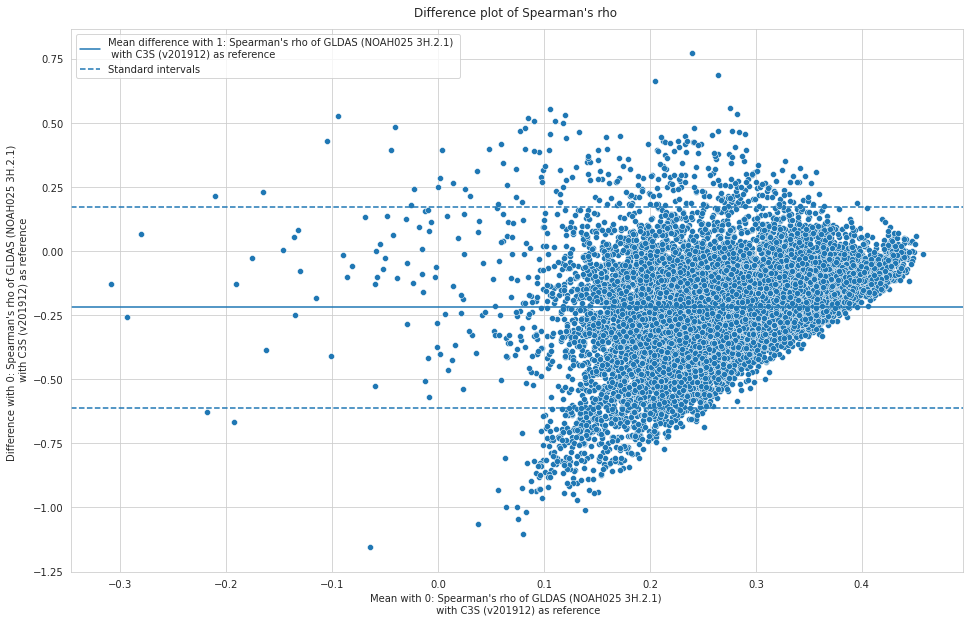

In [8]:
comp.diff_plot('rho')

#### Correlation plot

A correlation plot could show whether e.g. a dataset performs consistently throughout time, and whether there are strong outliers. Using a regression cal also show which of the two terms of comparison is performing better (i.e. if the slope is skewed on one side).

* **Should we make possible to have multiple comparisons plotted on the same image?**

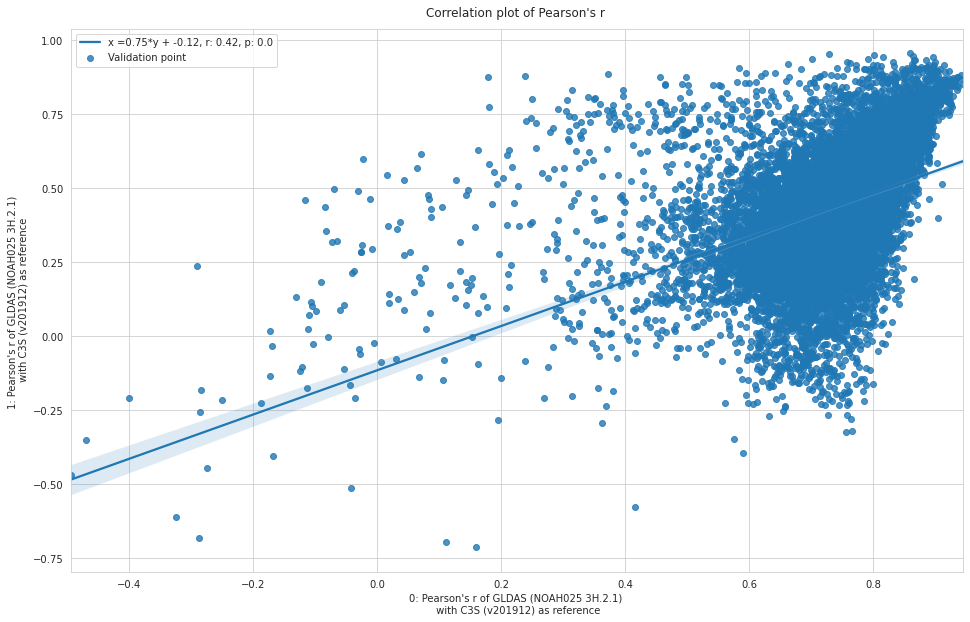

In [9]:
comp.corr_plot('R')

### Comparing different spatial subsets

Different validations may use different spatial subsets, which can completely overlap, intersect or correspond to entirely separate regions. This can create problems as some of the comparison methods depend on point-wise comparisons. Specifically, maps and correlation plots provide a point-by-point comparison. These methods therefore cannot be used to compare validations with non-overlapping spatial extents. To work around this, a flow diagram is established:

1. If `'extent'` is specified as class parameter, we take this extent, when valid, and perform the comparison over it. Otherwise, an error is thrown.
2. If the extent is not given, by default the class is initialized considering only the data present within the overlapping space of the two validations. If the validations are not overlapping, an error will be thrown to warn the user.
3. If the extent is not given and `get_intersection` is set to `False`, the comparison will take place between all the data present in each validation. In this case, using pairwise comparison methods will throw errors.

Let's now walk through this flow diagram. We can initialize two validation results, one with a spatial subset over Australia, one shifted to north-west, and see how the choice between union and intersection of the validation results plays out:

In [10]:
from qa4sm_reader.img import QA4SMImg

# paths to the validations with different spatial selections:
paths_subsets = ['0-C3S.sm_with_1-GLDAS.SoilMoi0_10cm_inst.nc', '0-C3S.sm_with_1-GLDAS.SoilMoi40_100cm_inst.diff_subset.nc']

for path in paths_subsets:
    img = QA4SMImg(path)
    print('Spatial extent of a single image:', img.extent)

Spatial extent of a single image: (106.125, 160.125, -43.375, -6.875)
Spatial extent of a single image: (92.625, 155.375, -27.875, 12.125)


In [11]:
%%time
# when we take the intersection, the initialization can be slow
comp_subsets = QA4SMComparison(paths_subsets)  # default: intersection of the spatial subsets

CPU times: user 15.1 s, sys: 90.8 ms, total: 15.2 s
Wall time: 15.2 s


We have now now initialized the comparison and we can see the two different spatial subsets:

(92.625, 160.125, -43.375, 12.125)

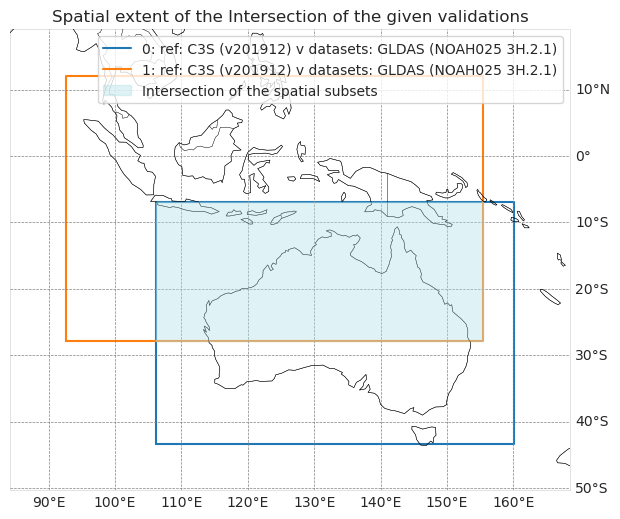

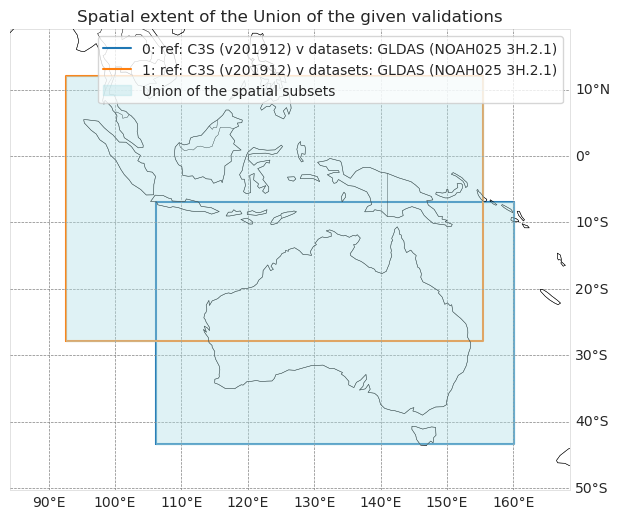

In [12]:
# method to visualize the outputs of union/intersection
comp_subsets.get_extent(visualize=True)
comp_subsets.get_extent(get_intersection=False, visualize=True)

Let's now select an extent over which to perform the validation:

In [13]:
%%time
comp_subsets = QA4SMComparison(paths_subsets, extent=(120, 140, -30, -10))

CPU times: user 9.34 s, sys: 79.8 ms, total: 9.42 s
Wall time: 9.42 s


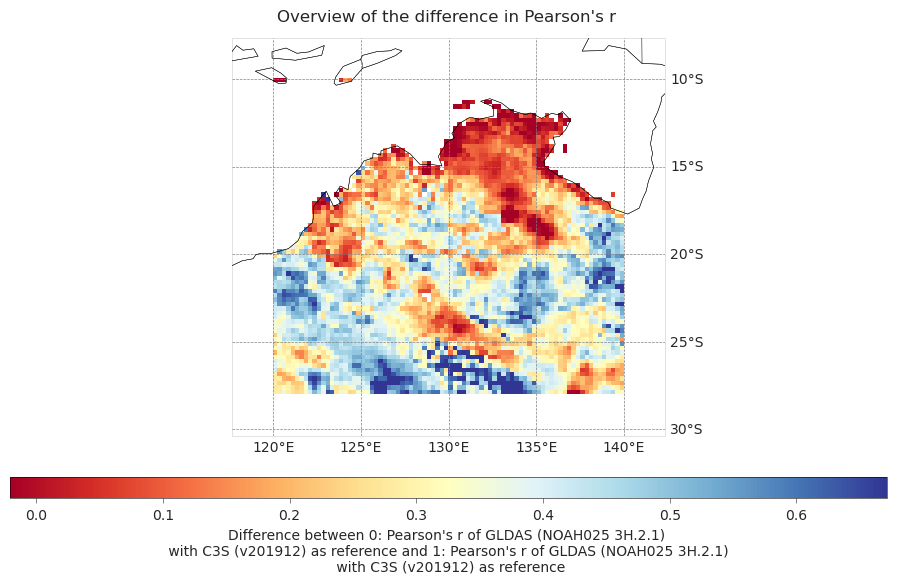

In [14]:
comp_subsets.diff_mapplot('R')

You can see that the comparison is performed correctly over our bounding box. Because one of the validations hase no points below ~-28 degrees South, these points do not show up.

Let's look deeper into what happens with the default settings. Because the default is `get_intersection=True`, all comparison methods (pairwise and not) provide results:

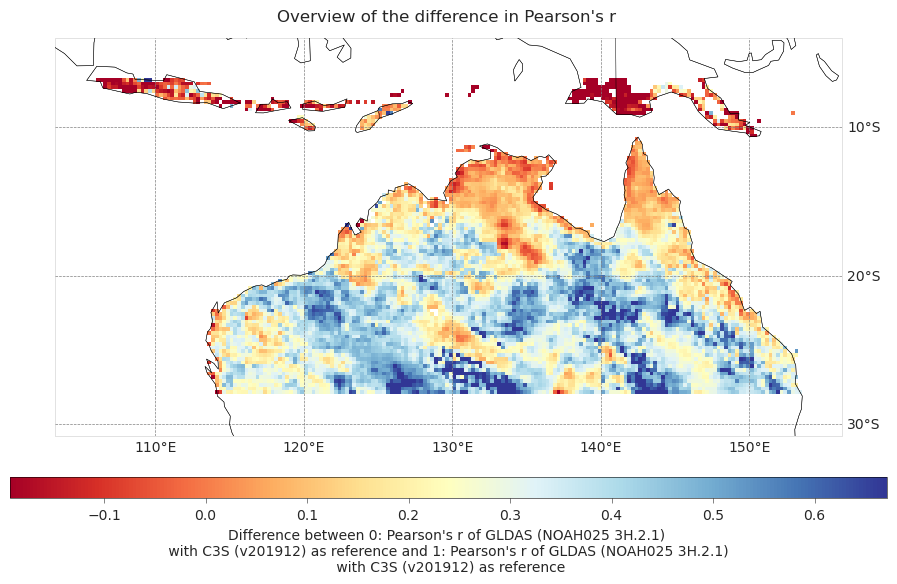

In [15]:
comp_subsets = QA4SMComparison(paths_subsets)  # default: intersection of the spatial subsets
comp_subsets.diff_mapplot('R')

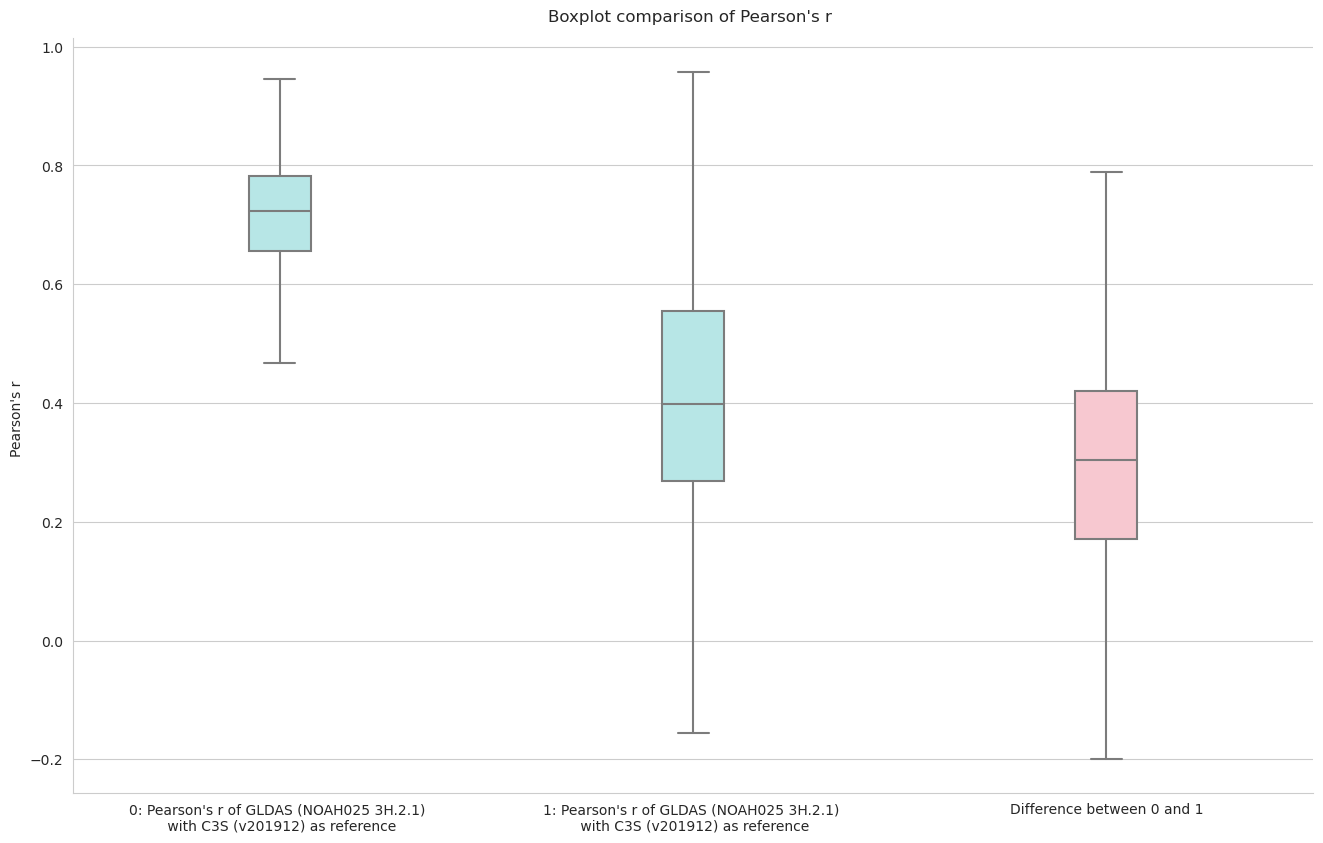

In [16]:
# the boxplots will be now different, as we are taking the intersection subset only
comp_subsets.diff_boxplot('R')

If instead we take the union, only `diff_table` and `diff_boxplot` can be used, while the pairwise methods throw errors. For instance:

In [17]:
%%time
# we can do either:
comp_subsets.init_union()

CPU times: user 745 ms, sys: 36 ms, total: 781 ms
Wall time: 780 ms


In [18]:
%%time
# or:
comp_subsets = QA4SMComparison(paths_subsets, get_intersection=False)

CPU times: user 771 ms, sys: 68.1 ms, total: 839 ms
Wall time: 838 ms


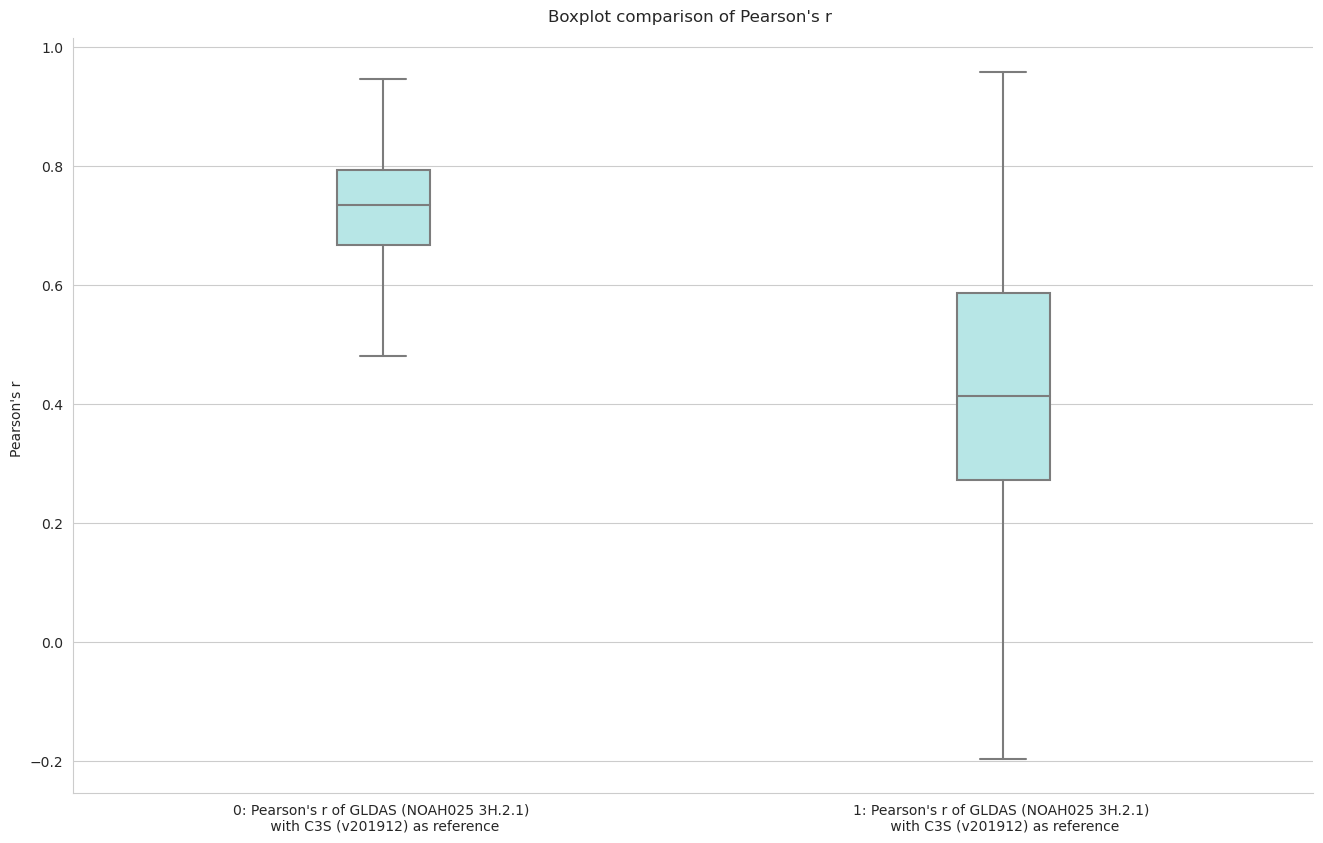

In [19]:
comp_subsets.diff_boxplot('R')

The difference boxplot is not provided, as it can be misinterpreted. In fact, now the two boxplots cannot be direcly subtracted, as they subtend different spatial extents.

In [20]:
# mapplot cannot be computed either
try:
    comp_subsets.diff_mapplot('R') 
except AssertionError:
    print("this won't work")

this won't work


### Intra-validation comparison

The comparison methods can be useful even when comparing two datasets that have been compared to the same reference in the same validation run. This might actually make the comparison more immediate as we are considering the same time and space subsets, as well as scaling functions applied. In this case, the path to a netCDF file containing (at least) three datasets can be provided as input to the class.

**Note**: the methods work at the moment only for validations with 2 satellite datasets
**Note2**: the diff_table method has yet to be implemented for this case

In [21]:
%%time
comp = QA4SMComparison('0-ERA5.swvl1_with_1-ESA_CCI_SM_combined.sm_with_2-ESA_CCI_SM_combined.sm.nc')

CPU times: user 573 ms, sys: 48.3 ms, total: 621 ms
Wall time: 997 ms


In [22]:
comp.diff_table()

,Median of 1-ESA CCI SM combined (v06.1),Median of 2-ESA CCI SM combined (v05.2),Difference of the medians (1 - 2)
Pearson's r,0.58,0.57,5.27e-03
Pearson's r p-value,0.e+00,0.e+00,0.e+00
Spearman's rho,0.55,0.55,9.12e-03
Spearman's rho p-value,0.e+00,0.e+00,0.e+00
Root-mean-square deviation,0.05,0.05,-1.15e-03
Bias (difference of means),0.e+00,0.e+00,0.e+00
Unbiased root-mean-square deviation,0.05,0.05,-1.15e-03
Mean square error,2.73e-03,2.85e-03,-1.22e-04
Mean square error correlation,2.73e-03,2.85e-03,-1.22e-04
Mean square error bias,3.39e-21,0.e+00,3.39e-21


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


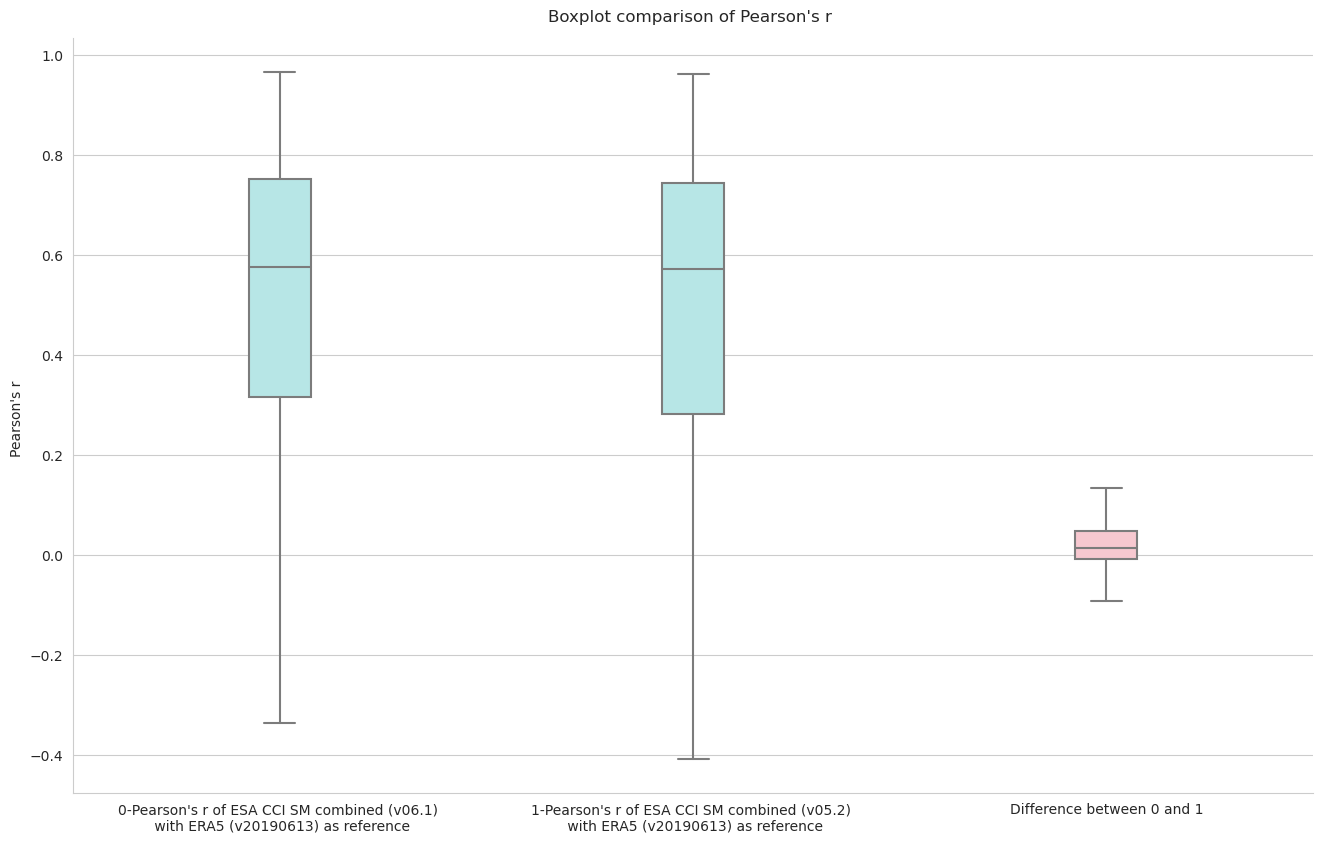

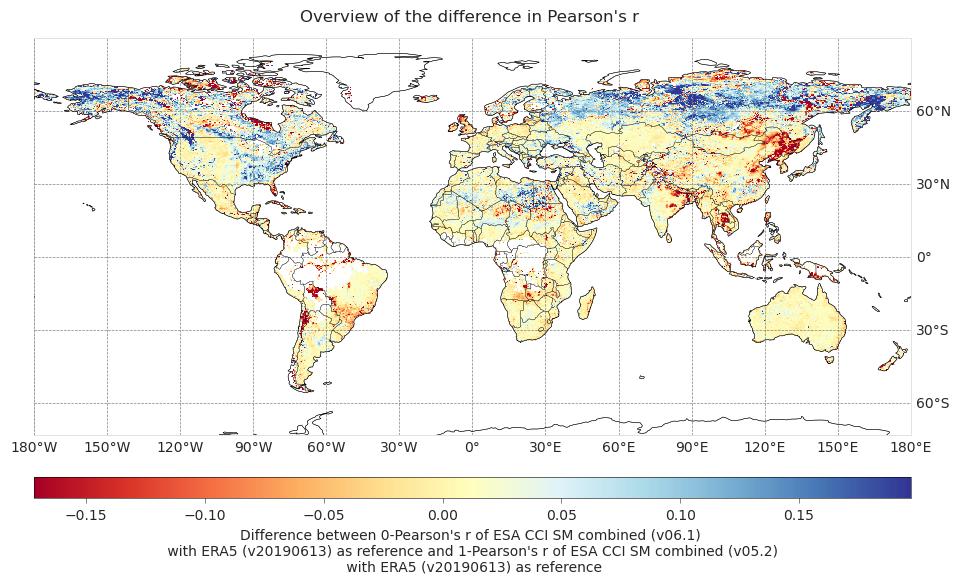

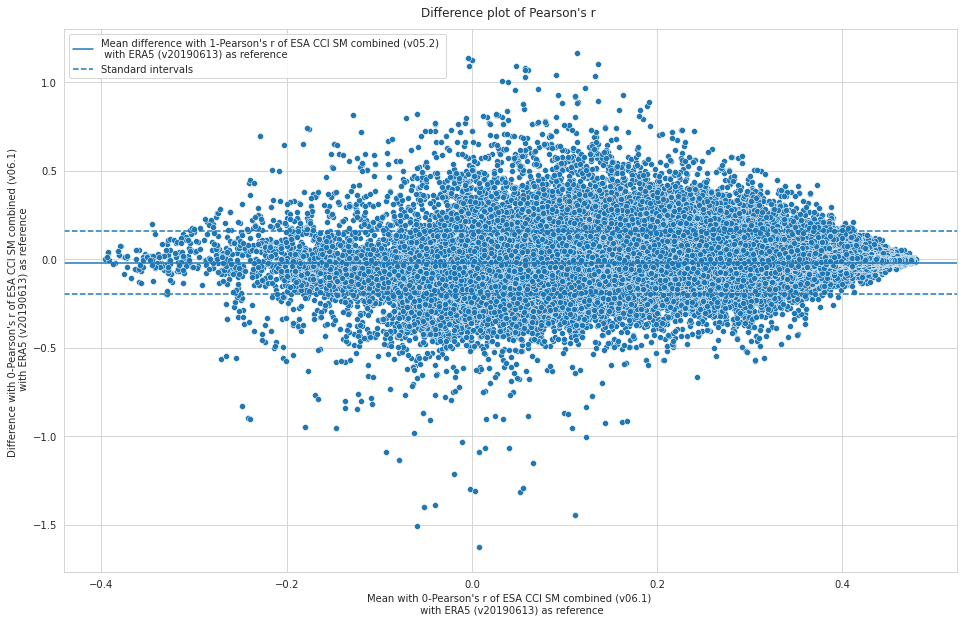

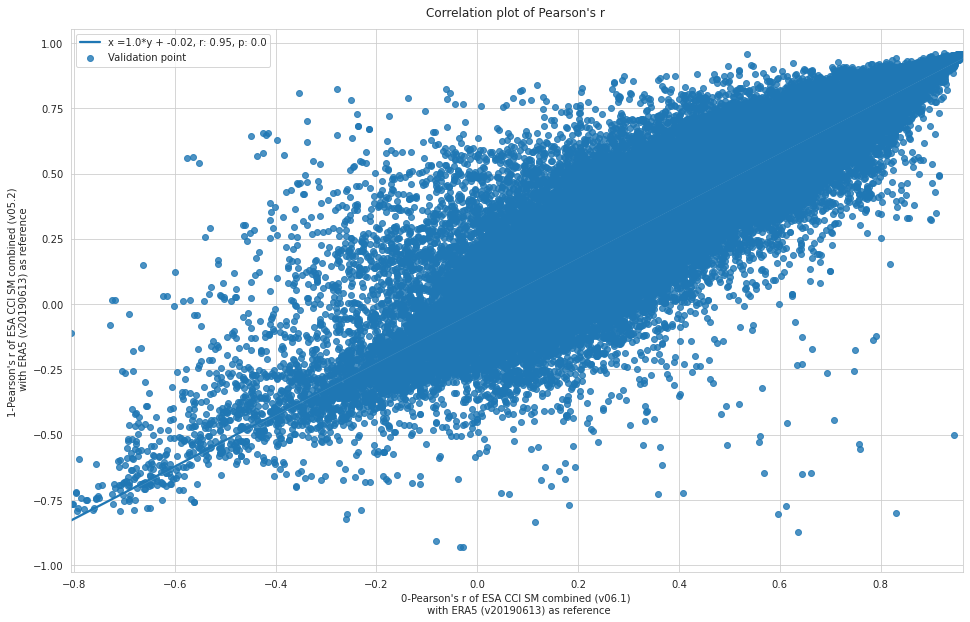

In [23]:
%time
comp.diff_boxplot('R')
comp.diff_mapplot('R')
comp.diff_plot('R')
comp.corr_plot('R')